# Word Embeddings for Aspect Models with Machine Learning

This notebook builds word vector embeddings and document vector embeddings which can be used in the machine learning classifiers. Word vector embeddings are multi-dimensional representations of text that are more sophisticated than the traditional bag of words or bag of ngrams models. These vectors take account of context, by considering relationships between words in terms of their position in the multi-dimensional vector space.

* Section 1 - Import libraries and data
* Section 2 - Data cleaning
* Section 3 - Using Word2Vec pretrained vectors
* Section 4 - Word2Vec custom embeddings (trained on the corpus)
* Section 5 - Sentence level vectors
* Section 6 - ML models using averaged word vectors
* Section 7 - Discussion about problems with word vectors
* Section 8 - Doc2Vec vectors
* Section 9 - ML models using Doc2Vec vectors

# Section 1: Import libraries and dataset

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

In [27]:
df_accom = pd.read_excel('combinedaspectcheck.xlsx',sheet_name = 'CLEANEDACCOM')
df_food = pd.read_excel("combinedaspectcheck.xlsx",sheet_name = "CLEANEDFOOD")
df_attract = pd.read_excel("combinedaspectcheck.xlsx", sheet_name = "CLEANEDATTRACT")

In [28]:
df_accom.head()

,OrigInd,Category,Cleaned,Noun Phrases,Nouns,Aspect,Sentiment
0,2030,Accommodation,main complaint room made u feel ill,main complaint room,complaint room,Room,-0.2960
1,10751,Accommodation,weekend away staff great room clean shower goo...,great room,room,Room,0.6249
2,11247,Accommodation,great room breakfast fabulous central location,great room breakfast fabulous,room breakfast,Room,0.8176
3,21902,Accommodation,shower great size well toiletry clean towel pr...,clean towel,towel,Room,0.4019
4,22835,Accommodation,great bed breakfast stayed week encore guest h...,lovely clean room facility,room facility,Room,0.7579


# Section 2: Preprocessing

In [29]:
# Drop column
df_accom.drop(["Category"],axis = 1, inplace = True)
df_food.drop(["Category"],axis = 1,inplace = True)
df_attract.drop(["Category"],axis = 1,inplace = True)

In [30]:
# Set to title case as some categories are multiples
df_accom["Aspect"] = df_accom["Aspect"].apply(lambda x: x.title())

In [31]:
# Function to specify X and y
def XY(df):
    X = df["Nouns"]
    y = df["Aspect"]

    return X,y

In [32]:
# Apply function and print shape
X_accom,y_accom = XY(df_accom)
X_food,y_food = XY(df_food)
X_attract,y_attract = XY(df_attract)

print(X_accom.shape,y_accom.shape)
print(X_food.shape,y_food.shape)
print(X_attract.shape,y_attract.shape)


(2220,) (2220,)
(2100,) (2100,)
(1650,) (1650,)


In [34]:
X_accom.head()

0    complaint room
1              room
2    room breakfast
3             towel
4     room facility
Name: Nouns, dtype: object

In [42]:
# Train, validation split
def train_test(X,y):
    X_train, X_val, y_train, y_val = train_test_split(X,y, stratify = y,test_size=0.20, shuffle = True)
    return X_train,X_val,y_train,y_val

In [43]:
# Run function
X_train_accom,X_val_accom,y_train_accom,y_val_accom = train_test(X_accom,y_accom)
X_train_food,X_val_food,y_train_food,y_val_food = train_test(X_food,y_food)
X_train_attract,X_val_attract,y_train_attract,y_val_attract = train_test(X_attract,y_attract)

In [44]:
# Shape of training, validation and test sets for each category
print(X_train_accom.shape, X_val_accom.shape, y_train_accom.shape, y_val_accom.shape)
print(X_train_food.shape, X_val_food.shape, y_train_food.shape, y_val_food.shape)
print(X_train_attract.shape,X_val_attract.shape, y_train_attract.shape, y_val_attract.shape)

(1776,) (444,) (1776,) (444,)
(1680,) (420,) (1680,) (420,)
(1320,) (330,) (1320,) (330,)


In [78]:
# Function to encode y values as integer labels (necessary for stratified cross validation as one-hot encoded doesn't work)
def lab(y_train, y_val):
    le = preprocessing.LabelEncoder()
    y_train_l = le.fit_transform(y_train)
    y_val_l = le.transform(y_val)
    return y_train_l, y_val_l

In [79]:
# Apply functions
y_train_accom_l, y_val_accom_l = lab(y_train_accom, y_val_accom)
y_train_food_l, y_val_food_l = lab(y_train_food, y_val_food)
y_train_attract_l, y_val_attract_l = lab(y_train_attract, y_val_attract)

# Section 3: Using Word2Vec Pretrained Vectors

In [45]:
# Import the gensim downloader to get pre-trained word embeddings from the glove-wiki-100 with vectors of length 100 (100
# dimensional space)
import gensim.downloader as api

In [46]:
# Download the glove corpora trained on wikipedia
wik_embed = api.load('glove-wiki-gigaword-100')

In [47]:
wik_embed['food']

array([-1.6486e-01,  9.1997e-01,  2.2737e-01, -4.9031e-01, -1.8082e-03,
       -3.3803e-01,  5.7221e-02,  1.4601e-01,  4.0202e-01, -2.8858e-01,
       -4.7495e-01, -5.6369e-01,  2.7037e-01,  5.1702e-01, -1.1241e-01,
        1.8314e-01,  2.2066e-01, -4.8606e-01, -8.7284e-01, -6.2587e-02,
        4.3016e-02,  2.3641e-01,  5.9705e-01, -3.8640e-01, -2.5194e-01,
        9.6862e-01, -4.3112e-01, -4.8370e-01, -1.1396e+00,  9.2425e-02,
       -1.1476e-01, -7.4291e-02, -6.2524e-02, -9.5122e-02, -2.2714e-01,
        8.8291e-01,  3.9978e-01,  7.6631e-01, -6.7697e-01, -6.2829e-01,
       -1.1872e-01, -2.4492e-01, -5.8893e-01, -8.5088e-01,  1.1107e+00,
        4.2190e-01, -1.5072e+00, -1.9509e-01, -2.6712e-01, -7.0801e-01,
        5.5075e-01, -4.6929e-02, -2.5203e-01,  7.4411e-01, -1.8325e-01,
       -1.4885e+00, -4.6393e-01, -1.0338e-01,  2.3525e+00, -1.5421e-01,
        3.9833e-01,  1.5344e-02,  8.0708e-02, -2.7373e-01,  9.7057e-01,
       -1.9383e-02,  2.0899e-01, -6.4033e-01,  9.2509e-01, -4.53

In [48]:
# Get most similar word vectors to food based on the large wikipedia corpus
wik_embed.most_similar('food')

[('foods', 0.7469059228897095),
 ('supplies', 0.726469099521637),
 ('products', 0.7225048542022705),
 ('meat', 0.7138239145278931),
 ('supply', 0.6732637882232666),
 ('feed', 0.6704155206680298),
 ('medicines', 0.6687097549438477),
 ('meals', 0.6630423069000244),
 ('coffee', 0.6627735495567322),
 ('goods', 0.6610530614852905)]

In [49]:
# Get most similar word vectors to food based on the large wikipedia corpus
wik_embed.most_similar('service')

[('services', 0.8831208348274231),
 ('public', 0.6898015737533569),
 ('network', 0.6799495220184326),
 ('private', 0.6653395891189575),
 ('system', 0.663616955280304),
 ('business', 0.6610175371170044),
 ('provided', 0.6580187082290649),
 ('available', 0.6564439535140991),
 ('information', 0.65455162525177),
 ('access', 0.653258204460144)]

In [50]:
wik_embed.most_similar(positive = ['pub'],topn = 200)

[('tavern', 0.7660407423973083),
 ('pubs', 0.7165777087211609),
 ('cafe', 0.6937366127967834),
 ('restaurant', 0.6867989301681519),
 ('inn', 0.6567275524139404),
 ('diner', 0.6390058398246765),
 ('saloon', 0.6300128698348999),
 ('nightclub', 0.6244509220123291),
 ('shop', 0.6084840297698975),
 ('café', 0.6015617847442627),
 ('brewery', 0.5947416424751282),
 ('dining', 0.575914740562439),
 ('hotel', 0.5699751377105713),
 ('barn', 0.5652211308479309),
 ('garage', 0.5638622641563416),
 ('lounge', 0.5610031485557556),
 ('bartender', 0.5576872825622559),
 ('bar', 0.5532839298248291),
 ('coffeehouse', 0.5503674149513245),
 ('eatery', 0.5502239465713501),
 ('restaurants', 0.5499460697174072),
 ('beer', 0.5485448241233826),
 ('taverns', 0.5417128205299377),
 ('supermarket', 0.5389108657836914),
 ('motel', 0.5370784997940063),
 ('proprietor', 0.5345678329467773),
 ('bistro', 0.5325350165367126),
 ('steakhouse', 0.5205979943275452),
 ('bookshop', 0.5188742280006409),
 ('brew', 0.5171971321105957

Pre-trained word vector embeddings are quick and easy to use but they are based on words in a large dataset so many not be as relevant to the nature of the review dataset being used. The most similar words shows the closely related words to the example word 'food'.

# Section 4: Word2Vec Custom Embeddings

In [68]:
# Run text through gensim cleaner to prep the data to remove the remaining punctuation etc.
X_train_accom2 = X_train_accom.apply(lambda x: gensim.utils.simple_preprocess(x))
X_train_food2 = X_train_food.apply(lambda x: gensim.utils.simple_preprocess(x))
X_train_attract2 = X_train_attract.apply(lambda x: gensim.utils.simple_preprocess(x))

# Validation
X_val_accom2 = X_val_accom.apply(lambda x: gensim.utils.simple_preprocess(x))
X_val_food2 = X_val_food.apply(lambda x: gensim.utils.simple_preprocess(x))
X_val_attract2 = X_val_attract.apply(lambda x: gensim.utils.simple_preprocess(x))

In [69]:
model_accom  = Word2Vec(X_train_accom2,size = 100, window = 10, min_count = 2, sample = 0.001)
model_food = Word2Vec(X_train_food2, size = 100, window = 10, min_count = 2, sample = 0.001)
model_attract = Word2Vec(X_train_attract2, size = 100, window = 10, min_count = 2, sample = 0.001)

In [60]:
model_food.wv.most_similar(positive = ['service'],topn = 10)

[('return', 0.3306557536125183),
 ('lunch', 0.32079005241394043),
 ('problem', 0.30830395221710205),
 ('order', 0.2962275743484497),
 ('option', 0.29264575242996216),
 ('meat', 0.24101652204990387),
 ('sign', 0.22967529296875),
 ('centre', 0.22923731803894043),
 ('surroundings', 0.22715196013450623),
 ('check', 0.22552557289600372)]

In [59]:
wik_embed.most_similar('service')

[('services', 0.8831208348274231),
 ('public', 0.6898015737533569),
 ('network', 0.6799495220184326),
 ('private', 0.6653395891189575),
 ('system', 0.663616955280304),
 ('business', 0.6610175371170044),
 ('provided', 0.6580187082290649),
 ('available', 0.6564439535140991),
 ('information', 0.65455162525177),
 ('access', 0.653258204460144)]

Compared to the pre-trained vectors in Section 1, the most similar words to the sample word 'food' are quite different and more focussed on the theme of reviews.

In [61]:
# List of most frequent words that appeared in the training data at least twice
print(model_food.wv.index2word,end = "")

['food', 'staff', 'value', 'menu', 'location', 'choice', 'money', 'quality', 'table', 'ambience', 'price', 'visit', 'service', 'restaurant', 'meal', 'lunch', 'order', 'taste', 'selection', 'variety', 'dirty', 'friend', 'drink', 'place', 'pub', 'helpful', 'experience', 'range', 'view', 'coffee', 'ok', 'plenty', 'beer', 'flavour', 'portion', 'breakfast', 'superb', 'wine', 'member', 'atmosphere', 'good', 'bit', 'glass', 'river', 'area', 'party', 'option', 'time', 'decor', 'fab', 'dish', 'family', 'veg', 'lamb', 'town', 'return', 'group', 'attentive', 'people', 'tasty', 'meat', 'holiday', 'lot', 'complaint', 'lack', 'kid', 'dessert', 'problem', 'pleasant', 'rude', 'fair', 'empty', 'garden', 'plate', 'gluten', 'dinner', 'year', 'starter', 'cake', 'minute', 'fault', 'chip', 'number', 'cafe', 'chair', 'disappointment', 'harvester', 'book', 'christmas', 'shame', 'surprise', 'presentation', 'vegan', 'birthday', 'bread', 'side', 'home', 'delay', 'ingredient', 'occasion', 'countryside', 'very', '

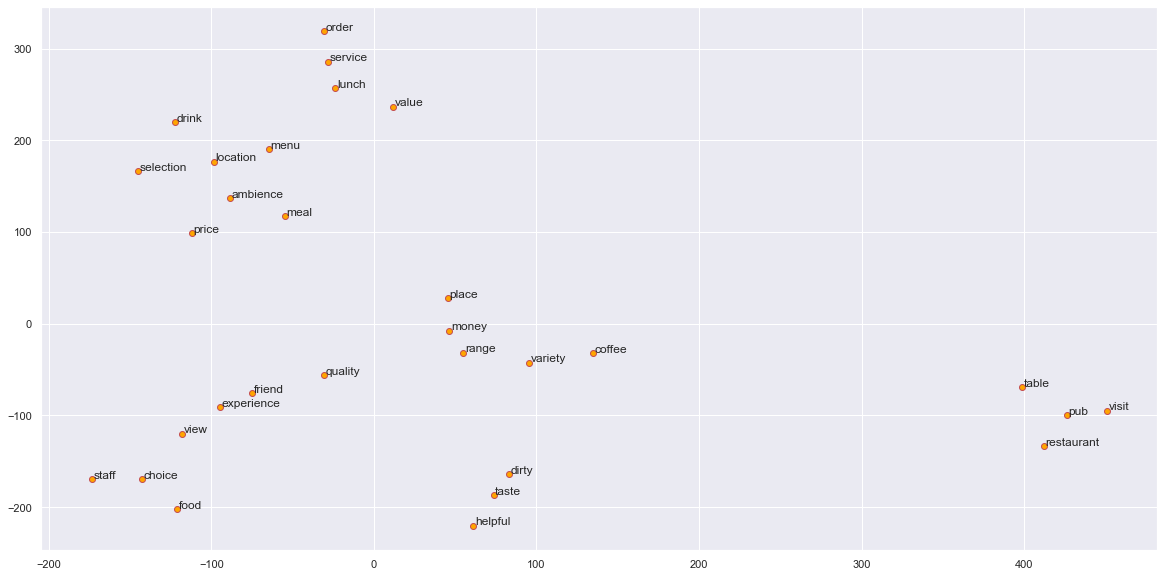

In [63]:
# visualise a range of the most frequent words in 2 dimensions:
words = ['food', 'staff', 'value', 'menu', 'location', 'choice', 'money', 
         'quality', 'table', 'ambience', 'price', 'visit', 'service', 
         'restaurant', 'meal', 'lunch', 'order', 'taste', 'selection', 'variety',
        'dirty', 'friend', 'drink', 'place', 'pub', 'helpful', 'experience',
         'range', 'view', 'coffee']
        
wvs = model_food.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(20,10))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

# Section 5: Create Sentence Level Vectors from the Word Vectors

Need to average all the individual word vectors in a review to get just one vector representation for each review.

In [64]:
# function to average word vectors for all words in each review.
# Code sourced from Dipanjan Sarkar "Text Analytics with Python" page 260

def average_word_vectors(words,model,vocabulary,num_features):
        feature_vector = np.zeros((num_features,),dtype = "float64")
        nwords = 0
    
        for word in words:
            if word in vocabulary:
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model[word])
        if nwords:
            feature_vector = np.divide(feature_vector,nwords)
        
        return feature_vector

def average_word_vectorizer(corpus,model,num_features):
    vocabulary = set(model.wv.index2word)
    features = corpus.apply(lambda x: average_word_vectors(x,model,vocabulary,num_features))
    features = pd.DataFrame(features.tolist(), index= features.index)
    return features

In [70]:
# Run the function to create averaged word vectors for the training and validation set
fv_accom = (average_word_vectorizer(corpus = X_train_accom2,model = model_accom.wv, num_features = 100))
fv_food = (average_word_vectorizer(corpus = X_train_food2,model = model_food.wv, num_features = 100))
fv_attract = (average_word_vectorizer(corpus = X_train_attract2,model = model_attract.wv, num_features = 100))

fv_accom_val = (average_word_vectorizer(corpus = X_val_accom2,model = model_accom.wv, num_features = 100))
fv_food_val = (average_word_vectorizer(corpus = X_val_food2,model = model_food.wv, num_features = 100))
fv_attract_val = (average_word_vectorizer(corpus = X_val_attract2,model = model_attract.wv, num_features = 100))

<ipython-input-64-ab28381b97c1>:18: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  vocabulary = set(model.wv.index2word)


# Section 6: ML Models using Averaged Word Vectors

In [73]:
# Set models - note NB doesn't run as negative values in the dataset
#nb = MultinomialNB()
clf1 = LogisticRegression(random_state=0, class_weight = "balanced")
clf2 = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0, class_weight = "balanced")
clf3 = LinearSVC(class_weight = "balanced")

In [87]:
# Stratified K Fold
def strat(model, X_train,y_train,vector):
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    cv_results = cross_val_score(model, X_train,y_train, cv=kfold)
    mean = cv_results.mean()
    df = pd.DataFrame({vector:mean},index = [0])
    return df

In [91]:
ac1 = strat(clf1, fv_accom, y_train_accom_l,"LR")
f1 = strat(clf1, fv_food, y_train_food_l,"LR")
t1 = strat(clf1, fv_attract, y_train_attract_l,"LR")

In [92]:
ac2 = strat(clf2, fv_accom, y_train_accom_l,"RF")
f2 = strat(clf2, fv_food, y_train_food_l,"RF")
t2 = strat(clf2, fv_attract, y_train_attract_l,"RF")

In [93]:
ac3 = strat(clf3, fv_accom, y_train_accom_l,"SVM")
f3 = strat(clf3, fv_food, y_train_food_l,"SVM")
t3 = strat(clf3, fv_attract, y_train_attract_l,"SVM")

In [95]:
# Training accuracies all models
models = ["Accom","Food","Attract"]
a = pd.concat([ac1,ac2,ac3],axis = 1)
b = pd.concat([f1,f2,f3],axis = 1)
c = pd.concat([t1,t2,t3],axis = 1)
all_models = pd.concat([a,b,c],axis = 0)
all_models.set_index([models],inplace = True)
all_models

,LR,RF,SVM
Accom,0.760119,0.695350,0.774767
Food,0.836310,0.831548,0.841667
Attract,0.597727,0.631818,0.601515


In [96]:
def prediction(model,X_train,y_train,X_val,y_val,labels):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_val)
    print(classification_report(y_val, y_pred))
    conf_mat = confusion_matrix(y_val, y_pred)
    fig, ax = plt.subplots(figsize=(10,8))
    ax = sns.heatmap(conf_mat, annot=True, fmt='d',
                     xticklabels=labels, yticklabels=labels)
    ax.set_ylabel('Actual',labelpad = 10)
    ax.set_xlabel('Predicted', labelpad = 13)
    plt.show()

In [97]:
labels_accom = ["Entertainment","Food","Hotel","Location","Room","Staff","Value"]
labels_food = ["Food Quality","Meal Exp","Menu Choice","Staff","Value","Visit Exp",""]
labels_attract= ["Activities","Amenities","History","Nature","Staff/Service","Value","VisitGen"]

## Accommodation

              precision    recall  f1-score   support

           0       0.60      0.63      0.62        70
           1       0.88      0.70      0.78        70
           2       0.87      0.94      0.90        70
           3       0.79      0.95      0.87        44
           4       0.67      0.54      0.60        70
           5       0.81      0.83      0.82        70
           6       0.77      0.88      0.82        50

    accuracy                           0.77       444
   macro avg       0.77      0.78      0.77       444
weighted avg       0.77      0.77      0.76       444



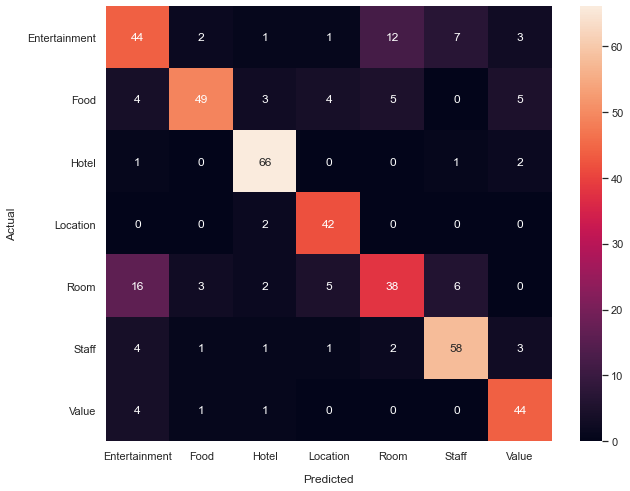

In [98]:
prediction(clf3,fv_accom,y_train_accom_l,fv_accom_val,y_val_accom_l,labels_accom)

## Food

              precision    recall  f1-score   support

           0       0.76      0.89      0.82        70
           1       0.78      0.81      0.80        70
           2       0.96      0.76      0.85        70
           3       0.97      1.00      0.99        70
           4       0.85      0.96      0.90        70
           5       0.80      0.67      0.73        70

    accuracy                           0.85       420
   macro avg       0.85      0.85      0.85       420
weighted avg       0.85      0.85      0.85       420



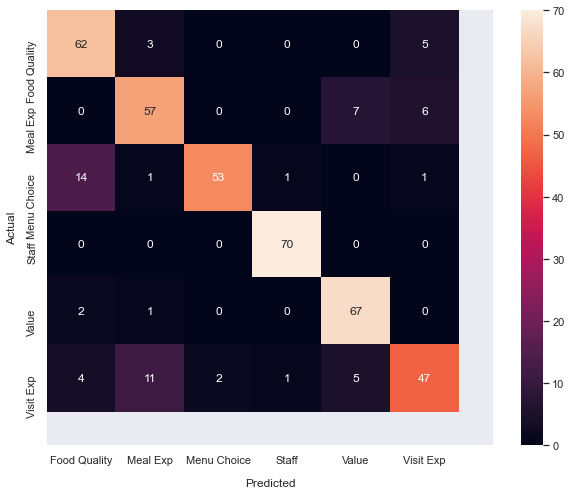

In [99]:
prediction(clf3,fv_food,y_train_food_l,fv_food_val,y_val_food_l,labels_food)

## Attractions

              precision    recall  f1-score   support

           0       0.56      0.72      0.63        60
           1       0.39      0.63      0.48        60
           2       1.00      0.23      0.38        30
           3       0.54      0.68      0.60        60
           4       0.80      0.40      0.53        40
           5       0.83      0.67      0.74        30
           6       0.76      0.44      0.56        50

    accuracy                           0.57       330
   macro avg       0.70      0.54      0.56       330
weighted avg       0.65      0.57      0.56       330



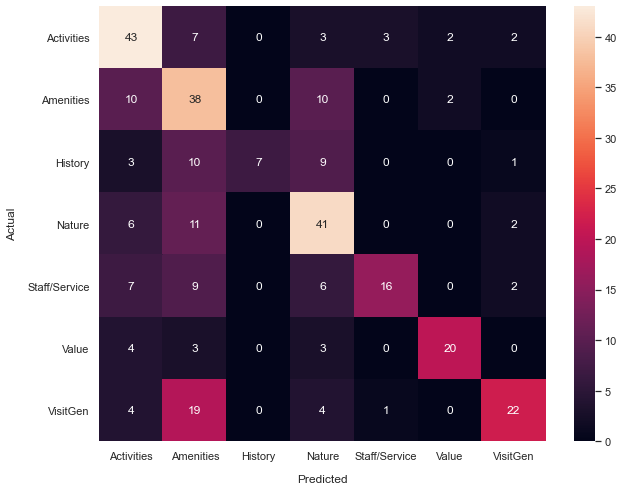

In [100]:
prediction(clf3,fv_attract,y_train_attract_l,fv_attract_val,y_val_attract_l,labels_attract)

Analysis:
* The results are pretty poor using average word vectors trained on the corpus

# Section 7: Problems with Word Embeddings with Word2Vec

Word2Vec returns a vector for each word and as such to get a vector for each document you can average the vectors for each word for each document which can provide vectors that are not very accurate and information is lost. Instead you can use Doc2Vec which returns a vector for each document and is more useful for the purposes of this dataset. This is much simpler and can be used directly in either machine learning or neural network models.

*Depending on the task you want to perform, you may simply average word embeddings of all words in the paragraph. (If doing so, you should normalize the word vectors first, so that they all have a norm equal to one.)*

*According to Kenter et al. 2016, this approach "has proven to be a strong baseline or feature across a multitude of tasks", such as short text similarity tasks.*

*However, according to Le and Mikolov, this method performs poorly for sentiment analysis tasks and/or long texts, because it "loses the word order in the same way as the standard bag-of-words models do" and "fail[s] to recognize many sophisticated linguistic phenomena, for instance sarcasm".*

# Section 8: Using Doc2Vec on review corpus

In [117]:
#Create tagged document objects. Useful for groups of documents for clustering. Return index and value for each review in 
# X_train.Source Code - Derek Jedamski 'Advanced NLP with Python' (03-03)

def tag(X_train,X_val):
    tagged_docs_train = [gensim.models.doc2vec.TaggedDocument(v, [i])
                     for i, v in enumerate(X_train)]
    tagged_docs_test = [gensim.models.doc2vec.TaggedDocument(v, [i])
                    for i, v in enumerate(X_val)]
    
    return tagged_docs_train, tagged_docs_test

In [119]:
tagged_docs_accom[0:2]

[TaggedDocument(words='window bedroom gap top', tags=[0]),
 TaggedDocument(words='restaurant food breakfast', tags=[1])]

In [122]:
# Run function
tagged_docs_accom,tagged_docs_accom_val = tag(X_train_accom, X_val_accom)
tagged_docs_food,tagged_docs_food_val = tag(X_train_food, X_val_food)
tagged_docs_attract,tagged_docs_attract_val = tag(X_train_attract, X_val_attract)

In [121]:
# Look at two examples of the tagged documents with list of words in the review followed by a tag
tagged_docs_accom[0:2]

[TaggedDocument(words='window bedroom gap top', tags=[0]),
 TaggedDocument(words='restaurant food breakfast', tags=[1])]

In [123]:
# Train doc2vec model with vector of 100, window of 5 words and words that appear at least twice
d2v_model = gensim.models.Doc2Vec(tagged_docs_train,
                                  vector_size=100,
                                  window=5,
                                  min_count=2)

In [124]:
# Prepare vectors for the training and test sets - stored as a list
tv_accom = [d2v_model.infer_vector(words) for words in X_train_accom2]
tv_accom_val = [d2v_model.infer_vector(words) for words in X_val_accom2]

tv_food = [d2v_model.infer_vector(words) for words in X_train_food2]
tv_food_val = [d2v_model.infer_vector(words) for words in X_val_food2]

tv_attract = [d2v_model.infer_vector(words) for words in X_train_attract2]
tv_attract_val = [d2v_model.infer_vector(words) for words in X_val_attract2]

In [125]:
# Example vector
tv_food[1]

array([-0.00216875,  0.00112238, -0.00264697,  0.00101317, -0.00182303,
       -0.00131618, -0.00495746,  0.00174435, -0.00033027,  0.00472722,
       -0.00441433, -0.00267177, -0.00468444, -0.00182579,  0.00488186,
       -0.00111305, -0.00484717, -0.00353052, -0.00252325,  0.00417315,
        0.00239303,  0.00136611,  0.00243315,  0.00460304,  0.00219655,
       -0.00467453,  0.00413925,  0.00025734, -0.00071626,  0.00161565,
        0.00429165,  0.00055879, -0.0042999 ,  0.00443917, -0.00224085,
        0.00249793, -0.00018819,  0.00465028,  0.00488656,  0.00031083,
       -0.00026273,  0.00154261, -0.00250906,  0.00469795,  0.00441918,
        0.00091349,  0.00162073,  0.00001463, -0.00391601, -0.00481869,
        0.00230806, -0.00010267, -0.00331535, -0.00405943, -0.00005788,
        0.00285475, -0.00423071, -0.00231804,  0.00227981,  0.00489594,
        0.00404778,  0.00379962,  0.00066241, -0.00226881,  0.00262704,
       -0.00352189,  0.00128872,  0.00287889,  0.00352753, -0.00

# Section 9: Run Doc2Vec Models Through ML Models

In [126]:
dac1 = strat(clf1, tv_accom, y_train_accom_l,"LR")
df1 = strat(clf1, tv_food, y_train_food_l,"LR")
dt1 = strat(clf1, tv_attract, y_train_attract_l,"LR")

In [127]:
dac2 = strat(clf2, tv_accom, y_train_accom_l,"RF")
df2 = strat(clf2, tv_food, y_train_food_l,"RF")
dt2 = strat(clf2, tv_attract, y_train_attract_l,"RF")

In [128]:
dac3 = strat(clf3, tv_accom, y_train_accom_l,"SVM")
df3 = strat(clf3, tv_food, y_train_food_l,"SVM")
dt3 = strat(clf3, tv_attract, y_train_attract_l,"SVM")

In [130]:
# Training accuracies all models
models = ["Accom","Food","Attract"]
da = pd.concat([dac1,dac2,dac3],axis = 1)
db = pd.concat([df1,df2,df3],axis = 1)
dc = pd.concat([dt1,dt2,dt3],axis = 1)
all_modelsd = pd.concat([da,db,dc],axis = 0)
all_modelsd.set_index([models],inplace = True)
all_modelsd

,LR,RF,SVM
Accom,0.394144,0.447712,0.415546
Food,0.510714,0.530357,0.511905
Attract,0.397727,0.446970,0.425758


The best model using document level vectors is SVM as before. The results are much worse than the previous models using an average sentence level vector. This might be because we are working with nouns and not real sentences. 

              precision    recall  f1-score   support

           0       0.37      0.23      0.28        70
           1       0.41      0.39      0.40        70
           2       0.49      0.61      0.54        70
           3       0.76      0.50      0.60        44
           4       0.33      0.27      0.30        70
           5       0.40      0.61      0.48        70
           6       0.56      0.58      0.57        50

    accuracy                           0.45       444
   macro avg       0.47      0.46      0.45       444
weighted avg       0.45      0.45      0.44       444



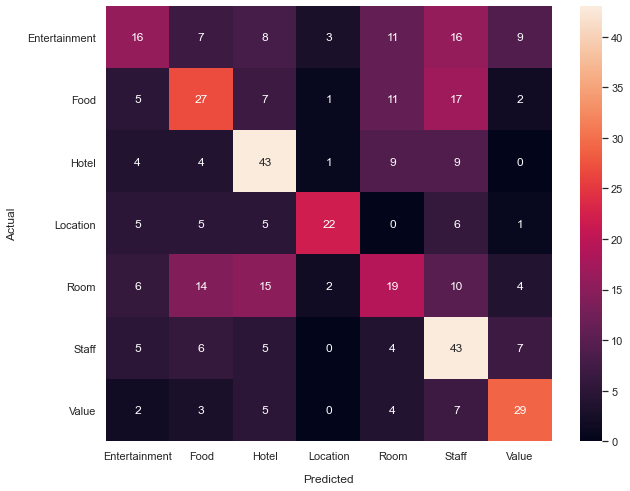

In [131]:
prediction(clf3,tv_accom,y_train_accom_l,tv_accom_val,y_val_accom_l,labels_accom)

              precision    recall  f1-score   support

           0       0.37      0.23      0.28        70
           1       0.41      0.39      0.40        70
           2       0.49      0.61      0.54        70
           3       0.76      0.50      0.60        44
           4       0.33      0.27      0.30        70
           5       0.40      0.61      0.48        70
           6       0.56      0.58      0.57        50

    accuracy                           0.45       444
   macro avg       0.47      0.46      0.45       444
weighted avg       0.45      0.45      0.44       444



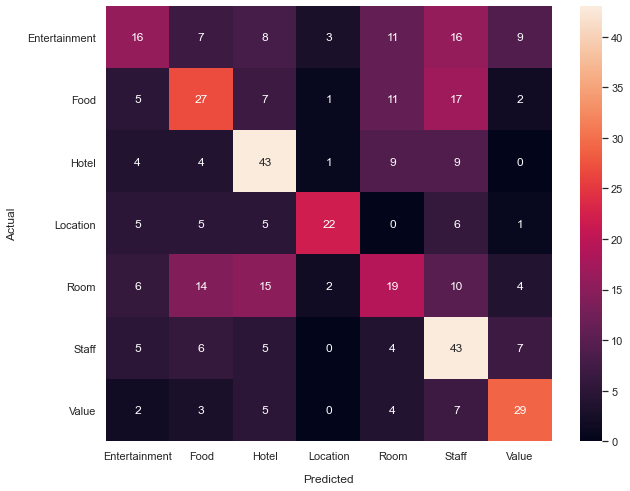

In [132]:
prediction(clf3,tv_accom,y_train_accom_l,tv_accom_val,y_val_accom_l,labels_accom)

              precision    recall  f1-score   support

           0       0.37      0.23      0.28        70
           1       0.41      0.39      0.40        70
           2       0.49      0.61      0.54        70
           3       0.76      0.50      0.60        44
           4       0.33      0.27      0.30        70
           5       0.40      0.61      0.48        70
           6       0.56      0.58      0.57        50

    accuracy                           0.45       444
   macro avg       0.47      0.46      0.45       444
weighted avg       0.45      0.45      0.44       444



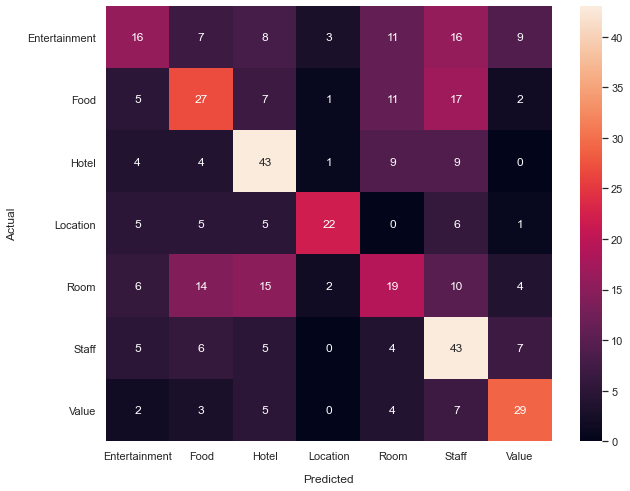

In [133]:
prediction(clf3,tv_accom,y_train_accom_l,tv_accom_val,y_val_accom_l,labels_accom)